In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import os
import seaborn as sb
import matplotlib as mpl
from matplotlib import pyplot as plt
import glob
from yaml import Loader, load
import pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
from matplotlib.ticker import FixedLocator

/home/fiona/anaconda3/envs/fluxrgnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_cv_results(models, base_dir, year=2017, trials=5, ext='', fluxes=True):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    radar_idx = dict()
    
    for i, (m, d) in enumerate(models.items()):

        # load predictions
        model_dir = osp.join(base_dir, m)
        result_list = []
        radar_idx_list = []
        for t in range(1, trials+1):
            file = osp.join(model_dir, f'test_{year}', d, f'trial_{t}', f'results{ext}.csv')
            if osp.isfile(file):
                df = pd.read_csv(file)
                df['trial'] = t
                result_list.append(df)
            
            radar_path = osp.join(osp.dirname(file), 'radar_index.pickle')
            if osp.isfile(radar_path):
                with open(radar_path, 'rb') as f:
                    radar_idx_list.append(pickle.load(f))
                    
            fp = osp.join(osp.dirname(file), 'config.yaml')
            if osp.isfile(fp):
                with open(fp) as f:
                    cfg = load(f, Loader=Loader)
                bird_scales[m] = cfg['datasource']['bird_scale']
                
        radar_idx[m] = radar_idx_list
        results[m] = pd.concat(result_list)
        
        
        print(f'successfully loaded results for {m}')
        
        # load fluxes
        if fluxes and 'Flux' in m:
            m_fluxes = [dict(), dict()]
            for t in range(1, trials+1):
                sub_dir = osp.join(model_dir, f'test_{year}', d, f'trial_{t}')
                          
                file = osp.join(sub_dir, f'model_fluxes{ext}.pickle')
                if osp.isfile(file):    
                    with open(osp.join(sub_dir, f'model_fluxes{ext}.pickle'), 'rb') as f:
                        m_fluxes[1][t] = pickle.load(f)
    
            all_fluxes[m] = m_fluxes

    return results, bird_scales, all_fluxes, radar_idx

In [3]:
def get_fluxes(voronoi, G, all_fluxes, results, model=1, context=24, H_start=0, H_end=64, seqID=None,
                net_fluxes=False, abm=False, radars=None):
    
        
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    if seqID is None:
        if model:
            f = torch.cat([f[..., H_start:H_end+1] for f in all_fluxes.values()], dim=-1).detach().numpy()
        else:
            f = np.concatenate([f[..., context+H_start:context+H_end+1] for f in all_fluxes.values()], axis=-1)
    else:
        if model:
            f = all_fluxes[seqID][..., H_start:H_end+1].detach().numpy()
        else:
            f = all_fluxes[seqID][..., context+H_start:context+H_end+1].detach().numpy()

    all_radars = voronoi.radar.values

    for i, ri in enumerate(all_radars):
        for j, rj in enumerate(all_radars):
            if radars is None or ri in radars or rj in radars:
                val = np.nansum(f[j,i])
                val2 = np.nansum(f[i,j])
                std = np.nanstd(f[j,i])

                if net_fluxes:
                    std = np.nanstd(f[j,i] - f[i,j])
                    val = val - val2
                if val > 0 and i !=j :
                    boundary1 = ('boundary' in ri) and ('boundary' in rj)
                    boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()

                    if not boundary1 and not boundary2:
                        G_new.add_edge(j, i, flux=val, std=std)
                        
    return G_new

def plot_fluxes(voronoi, G, ax, countries, bird_scale=1, extent=None, label='net migratory flux',
                crs=None, max_flux=None, cbar=True, scale=1, grid=True):
    ax.set_extent(extent)
    f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
    ax.add_feature(f, facecolor='lightgray', zorder=0)
    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                     observed = voronoi.observed,
                                     geometry = [geometry.Point((row.lon, row.lat)) for 
                                             i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, 
                  coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G,'flux').values()))
    fluxes *= bird_scale
    if max_flux is None:
        max_flux = np.max(fluxes)
    edge_widths = np.minimum(fluxes, max_flux) / (0.25 * max_flux) + 1.5
    edge_widths *= scale

    c_radar = 'lightgray'
    c_marker = '#0a3142'
    node_colors = ['#999999' if 'boundary' in n_data['radar'] else c_radar for n, n_data in G.nodes(data=True)]
    node_colors = [c_radar for n, n_data in G.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    
    norm = plt.Normalize(0, max_flux)
    edge_colors = cmap(norm(fluxes))
    
    if scale == 1:
        node_size = 12000/len(G)
    else:
        node_size = scale*1000/len(G)
    nx.draw(G, pos=pos, with_labels=False, node_size=node_size, node_color=node_colors, ax=ax, 
            #options={'arrowsize': edge_widths*50}, 
            connectionstyle="arc3,rad=0.1", 
                  edge_color=edge_colors, width=edge_widths) #, zorder=2)

    gplt.polyplot(coord_df.query('observed == 1').buffer(20_000*scale).to_crs(epsg=4326), 
                  ax=ax, zorder=3, edgecolor=c_marker, extent=extent, linewidth=1.5)
    gplt.polyplot(coord_df.query('observed == 0').buffer(20_000*scale).to_crs(epsg=4326), 
                  ax=ax, zorder=3, edgecolor=c_marker, extent=extent, linewidth=2)
    gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), 
                   ax=ax, zorder=4, color=c_marker, extent=extent, s=6*scale)


    if cbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(sm, extend='max')
        cbar.set_label(label=label ,size=24, labelpad=18)
        cbar.ax.tick_params(labelsize=18) 
    
    if grid:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, color='gray', alpha=0.25, linestyle='--')

        xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
        yspacing = FixedLocator([40, 45, 50, 55])
        gl.xlocator = xspacing
        gl.ylocator = yspacing
    
    return ax, max_flux

In [4]:
c_radar_loc = '#cc3300'
c_radar_area = '#347B98'
c_marker = '#0a3142'
c_boundary = '#092834'
c_boundary_rgb = (9/255, 40/255, 52/255, 0.2)
c_boundary_light = '#0a3142'
c_text = '#262626'
c_countries = 'lightgray'

### ***Define file paths***

In [5]:
base_dir = osp.dirname(os.getcwd())

result_dir = osp.join(base_dir, 'results', 'radar')
output_dir = osp.join(base_dir, 'data', 'plots', 'test')
os.makedirs(output_dir, exist_ok=True)
shape_dir = osp.join(base_dir, 'data', 'shapes')
prep_dir = osp.join(base_dir, 'data', 'preprocessed', 
                    '1H_voronoi_ndummy=15', 'radar', 'fall', '2017')

In [6]:
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
countries = gpd.read_file(osp.join(shape_dir, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)
extent = voronoi.total_bounds
extent[1] -= 0.5

### ***Weather radars and Voronoi tessellation***

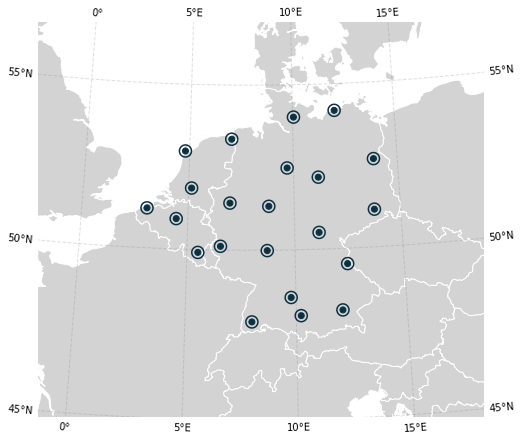

In [8]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)

coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 observed = voronoi.observed,
                                 geometry = [geometry.Point((row.lon, row.lat)) for 
                                             i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs.proj4_init)

gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), 
              ax=ax, zorder=3, edgecolor=c_marker, extent=extent, linewidth=1.5)
gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), 
               ax=ax, zorder=4, color=c_marker, extent=extent, s=6)

        
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing
        
fig.savefig(osp.join(output_dir, 'radar_locations.png'), bbox_inches='tight', dpi=200)

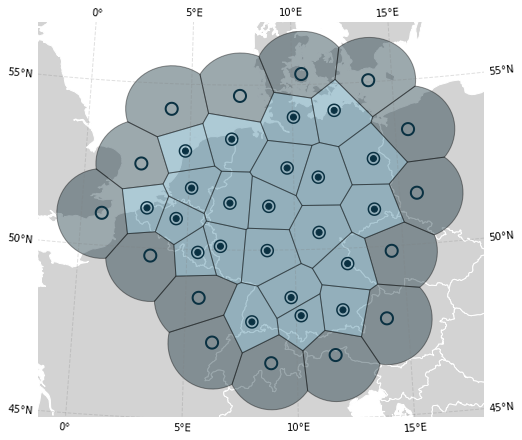

In [9]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)

gplt.polyplot(voronoi.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.4, extent=extent, zorder=2)
gplt.polyplot(voronoi.query('boundary == 0'), ax=ax, facecolor=c_radar_area, alpha=0.4, extent=extent, zorder=2)

coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 observed = voronoi.observed,
                                 geometry = [geometry.Point((row.lon, row.lat)) for 
                                             i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs.proj4_init)

gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), 
              ax=ax, zorder=3, edgecolor=c_marker, extent=extent, linewidth=1.5)
gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), 
              ax=ax, zorder=3, edgecolor=c_marker, extent=extent, linewidth=2)
gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), 
               ax=ax, zorder=4, color=c_marker, extent=extent, s=6)
        
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing
        
fig.savefig(osp.join(output_dir, 'voronoi_radar.png'), bbox_inches='tight', dpi=200)

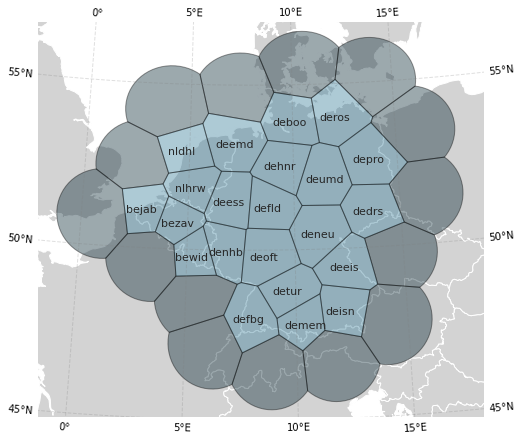

In [10]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)

gplt.polyplot(voronoi.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.4, extent=extent, zorder=2)
gplt.polyplot(voronoi.query('boundary == 0'), ax=ax, facecolor=c_radar_area, alpha=0.4, extent=extent, zorder=2)

centroids = voronoi.to_crs(crs.proj4_init).centroid
for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, voronoi.radar):
    if not 'boundary' in label:
        ax.annotate(label, xy=(x, y), xytext=(-18, -5), textcoords="offset points", fontsize=11, color=c_text)
        
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
gl.xlocator = xspacing
gl.ylocator = yspacing
        
fig.savefig(osp.join(output_dir, 'voronoi_radar_names.png'), bbox_inches='tight', dpi=200)

### ***Visualisation of nightly fluxes***

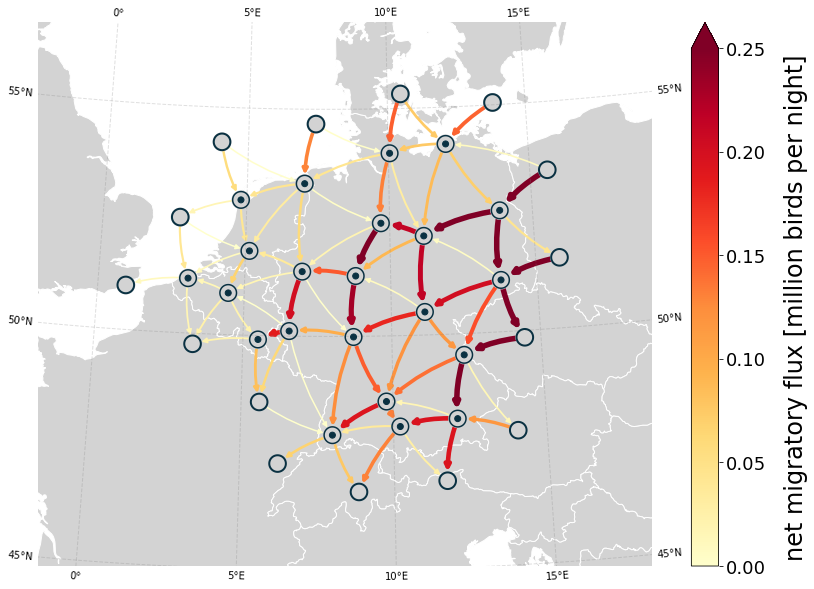

In [12]:
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})

trial = 2

if not trial in range(1,6):
    all_G = {}
    for t in range(1,6):
        all_G[t] = nx.read_gpickle(osp.join(result_dir, 'FluxRGNN', 'test_2017', 'final', 
                        'performance_evaluation_fixedT0', '1-24', f'model_fluxes_{trial}.gpickle'))
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(all_G[2].nodes(data=True)))  
    for i, j in it.combinations(list(G_new.nodes()), 2):
        fluxes_ij = []
        fluxes_ji = []
        for t, G in all_G.items():
            data_ij = G.get_edge_data(i, j, default=None)
            data_ji = G.get_edge_data(j, i, default=None)
            if data_ij is not None:
                fluxes_ij.append(data_ij['flux'])
                fluxes_ji.append(-data_ij['flux'])
            if data_ji is not None:
                fluxes_ij.append(-data_ji['flux'])
                fluxes_ji.append(data_ji['flux'])
        if len(fluxes_ij):
            f_ij = np.nanmean(fluxes_ij)
            f_ji = np.nanmean(fluxes_ji)
            if f_ij > 0:
                G_new.add_edge(i, j, flux=f_ij)
            else:
                G_new.add_edge(j, i, flux=f_ji)   
else:
    G_new = nx.read_gpickle(osp.join(result_dir, 'FluxRGNN', 'test_2017', 'final', 
                        'performance_evaluation_fixedT0', '1-24', f'model_fluxes_{trial}.gpickle'))

ax, max_flux = plot_fluxes(voronoi, G_new, ax, countries, bird_scale=1e-6, max_flux=0.25, extent=extent,
                        crs=crs.proj4_init, label=r'net migratory flux [million birds per night]')

fig.savefig(osp.join(output_dir, f'radar_avg_nightly_fluxes_model_trial_{trial}.png'), bbox_inches='tight', dpi=200)

### ***Example predictions***

In [7]:
models = {'FluxRGNN': 'final'}
r, bs, fluxes, ridx = load_cv_results(models, result_dir, year=2017, ext='_fixedT0', fluxes=True, trials=5)

features = pd.read_csv(osp.join(prep_dir, 'dynamic_features.csv'))

successfully loaded results for FluxRGNN


#### Single radar

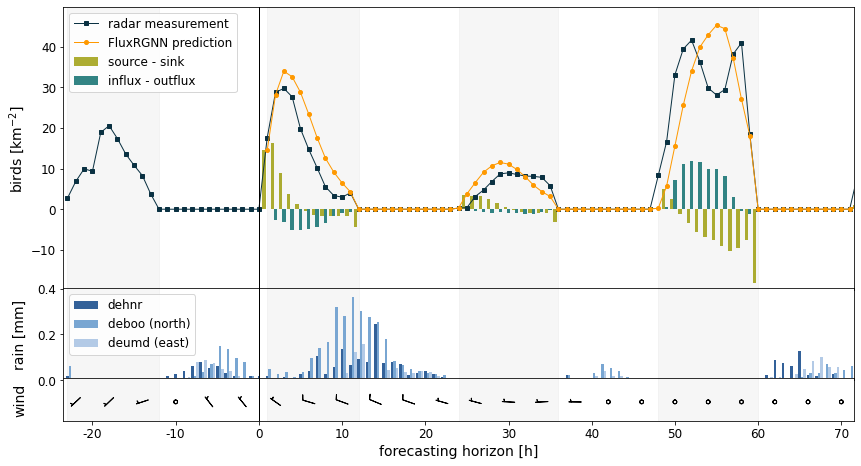

In [18]:
radar = 'dehnr'
adj = {'deboo': 'deboo (north)', 
       'deumd': 'deumd (east)'}

trial = 2
seqID = 13

df = r['FluxRGNN'].query(f'radar == "{radar}"& seqID == {seqID} & trial == {trial}').copy()

tidx = r['FluxRGNN'].query(f'radar == "{radar}"& seqID == 13').tidx.values

df_rad = features.query(f'radar == "{radar}"')
df_rad = df_rad[df_rad.tidx.isin(tidx)]

fig, ax = plt.subplots(3, figsize=(11.5, 6), gridspec_kw={'height_ratios': [4, 1.3, 0.6]})

#####################################################################
# prediction plot
#####################################################################
ax[0].plot(df.horizon.values, df.gt_km2.values, marker='s', ms=4, linewidth=1, 
           color=c_marker, label='radar measurement')
ax[0].plot(df.horizon.values, df.prediction_km2.values, marker='o', ms=4, linewidth=1, 
           color='#ff9900', label='FluxRGNN prediction')

df['source_sink'] = df.apply(lambda row: row.source_km2 - row.sink_km2, axis=1)
df['net_flux'] = df.apply(lambda row: row.influx_km2 - row.outflux_km2, axis=1)

maxy = max(df['gt_km2'].max(), df['prediction_km2'].max())
maxy += maxy/10
miny = min(df['source_sink'].min(), df['net_flux'].min())
miny += miny/10

xrange1 = np.arange(-24, 72)
ax[0].bar(xrange1+0.6, df.source_sink.values, width=0.4, alpha=0.8, 
          label='source - sink', color='#999900', edgecolor=None)
ax[0].bar(xrange1+1, -df.net_flux.values, width=0.4, alpha=0.8, 
          label='influx - outflux', color='#006666')

dusk = 0
dawn = 0
day = 1
for i, row in df.iterrows():
    if not row.night and not day:
        dawn = row.horizon
        day = 1
        ax[0].fill_between([dawn, dusk], miny, maxy, color='lightgray', alpha=0.2, zorder=0)
        ax[1].fill_between([dawn, dusk], miny, maxy, color='lightgray', alpha=0.2, zorder=0)
        ax[2].fill_between([dawn, dusk], miny, maxy, color='lightgray', alpha=0.2, zorder=0)
    elif row.night and day:
        dusk = row.horizon
        day = 0

ax[0].set_ylabel(r'birds [km$^{-2}$]', fontsize=14)
ax[0].set_xlabel(None)
ax[0].set_xticks([])
ax[0].set(xlim=(-23.5, 71.5), ylim=(miny, maxy))
ax[0].tick_params(axis='y', which='major', labelsize=12)

ax[0].legend(loc='upper left', fontsize=12)

plt.subplots_adjust(hspace=None)

#####################################################################
# env plot
#####################################################################

df_rad['tp_mm'] = df_rad.tp * 1000
c_rad = '#336199'
c_adj = ['#79a6d2', '#b3cae6']

width = .9/(len(adj)+1)
ax[1].bar(xrange1, df_rad.tp_mm.values, width=width, alpha=1, color=c_rad, label=radar)

tp_mm_max = df_rad.tp_mm.max()
for i, (a, label) in enumerate(adj.items()):
    df_a = features.query(f'radar == "{a}"')
    df_a = df_a[df_a.tidx.isin(tidx)]
    df_a['tp_mm'] = df_a.tp * 1000
    if df_a.tp_mm.max() > tp_mm_max:
        tp_mm_max = df_a.tp_mm.max()

    ax[1].bar(xrange1+(1+i)*width, df_a.tp_mm.values, width=width, alpha=1, color=c_adj[i], label=label)
    
ax[1].set(xticks=[], xlabel=None, xlim=(-23.5, 71.5), ylim=(0, tp_mm_max * 1.1))
ax[1].set_ylabel('rain [mm]', fontsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=12)
ax[1].legend(fontsize=12)

start = 2
end = start + 72 + 24
step = 4
xrange2 = np.arange(start, end, step)
ax[2].barbs(xrange2-24, np.ones(xrange2.shape), #*df_seq.tp_mm.max()*0.7, 
            df_rad.u.values[start:end:step], df_rad.v.values[start:end:step], length=5, pivot='middle')
ax[2].set(xticks=np.arange(4, xrange1.size, 10)-24, xticklabels=xrange1[4::10], yticks=[], 
          xlim=(-23.5, 71.5), ylim=(0.2, 2))
ax[2].set_xlabel('forecasting horizon [h]', fontsize=14)
ax[2].set_ylabel('wind', fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=12)

for axis in ax:
    axis.axvline(0, ls='-', lw=1, color='k', zorder=3)

fig.align_ylabels(ax)
fig.tight_layout(pad=-1)
fig.savefig(osp.join(output_dir, 'radar_dehnr_seq13_trial2_with_env.png'), bbox_inches='tight', dpi=200)

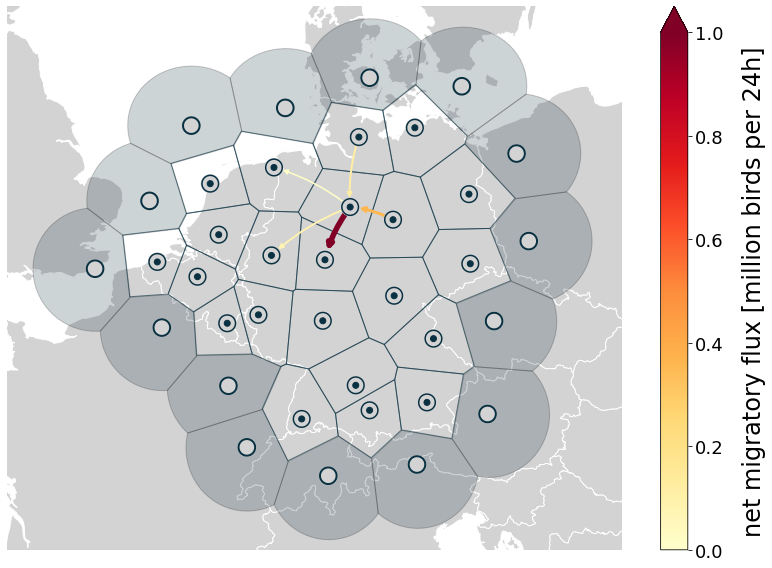

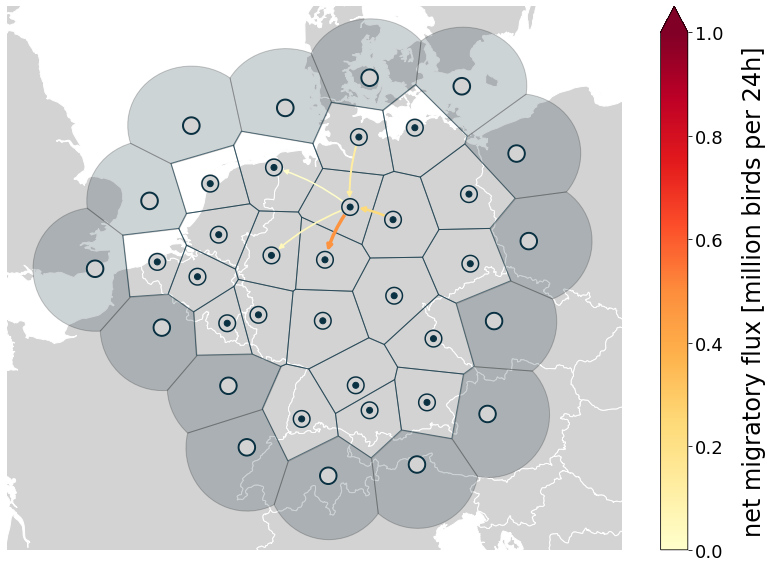

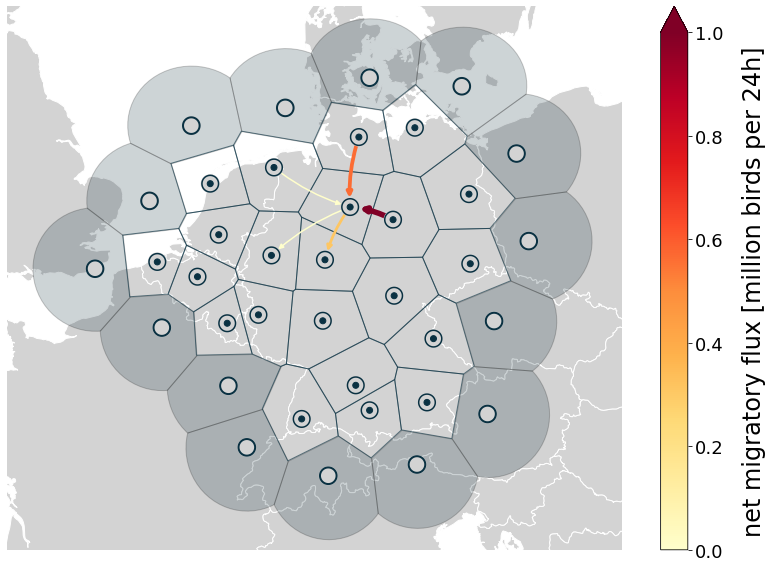

In [16]:
H_start, H_end = 0, 24

G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)

for H_start in [0, 24, 48]:
    H_end = H_start + 24
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})

    gplt.polyplot(voronoi.query('boundary == 1'), ax=ax, facecolor=c_boundary, 
                  alpha=0.2, extent=extent, zorder=1)
    gplt.polyplot(voronoi.query('boundary == 0'), ax=ax, edgecolor=c_boundary_light, 
                  alpha=0.6, extent=extent, zorder=1)

    G_model = get_fluxes(voronoi, G, fluxes['FluxRGNN'][1][trial], r['FluxRGNN'], 
                         model=1, H_start=H_start, H_end=H_end, seqID=seqID,
                         net_fluxes=True, abm=False, radars=['dehnr'])

    ax, max_flux = plot_fluxes(voronoi, G_model, ax, countries, bird_scale=1e-6, max_flux=1,
                              extent=extent, crs=crs.proj4_init, grid=False,
                              label=r'net migratory flux [million birds per 24h]')

    fig.savefig(osp.join(output_dir, f'radar_inferred_net_fluxes_trial{trial}_seq{seqID}_{H_start}-{H_end}.png'), 
                bbox_inches='tight', dpi=300)

#### All radars

/home/fiona/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


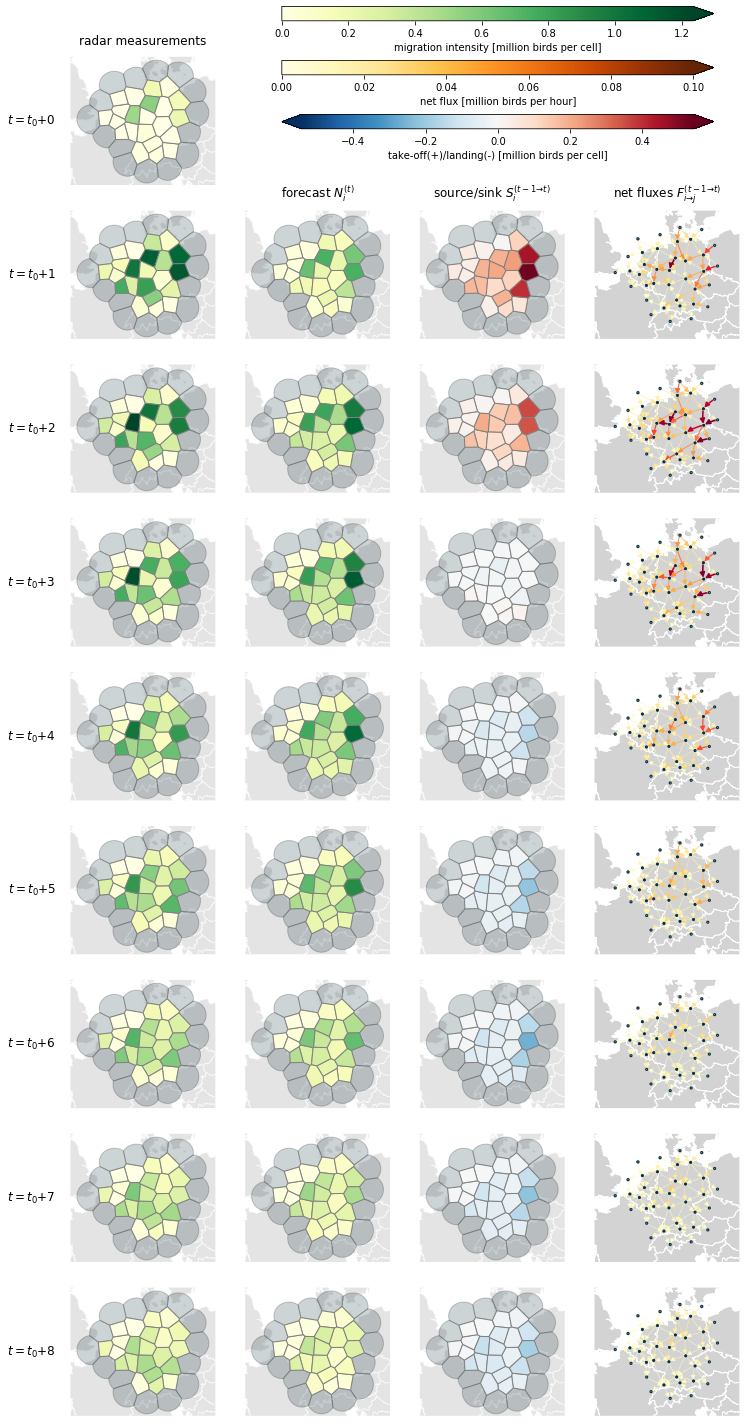

In [108]:
cmap = cm.get_cmap('YlGn')

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white', alpha=0.6)
G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)


# seqID = 26 or 38 or 47 or 52
seqID = 47
trial = 1
T = 9

data = r['FluxRGNN'].query(f'seqID == {seqID} & trial == {trial}')
data['gt'] = data.gt_km2 * data.area
data['pred'] = data.prediction_km2 * data.area
norm = mpl.colors.Normalize(vmin=0, vmax=(data['gt'].max()*1e-6)-0.2)

data['source_sink'] = (data.source_km2 - data.sink_km2) * data.area
abs_max = max(abs(data.source_sink.min()), data.source_sink.max())
source_sink_norm = mpl.colors.Normalize(vmin=-abs_max*1e-6, vmax=abs_max*1e-6)

flux_norm = mpl.colors.Normalize(vmin=0, vmax=0.1)

dt = data.query(f'horizon >= 0 & horizon <{T}').datetime
print(f'start: {dt[0]}')
print(f'end  : {dt[-1]}')

fig, ax = plt.subplots(T, 4, figsize=(12,25), subplot_kw = {'projection' : crs})

for t in range(T):
    for i in range(3):
        ax[t, i].add_feature(f, facecolor=c_countries, zorder=0)

    data_t = data.query(f'horizon == {t}')
    datetime = pd.to_datetime(data_t.datetime.iloc[0]).strftime("%H:%M:%S")
    gt_t = dict(zip(data_t.radar.values, data_t['gt'].values))
    pred_t = dict(zip(data_t.radar.values, data_t['pred'].values))
    source_sink_t = dict(zip(data_t.radar.values, data_t.source_sink.values))
    voronoi['source_sink_birds'] = voronoi.apply(lambda row: source_sink_t[row.radar]*1e-6, axis=1)
    voronoi['gt_birds'] = voronoi.apply(lambda row: gt_t[row.radar]*1e-6, axis=1)
    voronoi['pred_birds'] = voronoi.apply(lambda row: pred_t[row.radar]*1e-6, axis=1)

    gplt.polyplot(voronoi.query('boundary == 1'), ax=ax[t, 0], facecolor=c_boundary, 
                  alpha=0.2, extent=extent, zorder=2)
    gplt.choropleth(voronoi.query('boundary == 0'), ax=ax[t, 0], hue='gt_birds', 
                    cmap = cmap, edgecolor='gray', norm=norm,
                    alpha=1, extent=extent, zorder=2, legend=False)
    gplt.polyplot(voronoi.query('boundary == 1'), ax=ax[t, 1], facecolor=c_boundary, 
                  alpha=0.2, extent=extent, zorder=2)
    gplt.choropleth(voronoi.query('boundary == 0'), ax=ax[t, 1], hue='pred_birds', 
                    cmap = cmap, edgecolor='gray', norm=norm,
                    alpha=1, extent=extent, zorder=2, legend=False)
    gplt.polyplot(voronoi.query('boundary == 1'), ax=ax[t, 2], facecolor=c_boundary, 
                  alpha=0.2, extent=extent, zorder=2)
    gplt.choropleth(voronoi.query('boundary == 0'), ax=ax[t, 2], hue='source_sink_birds', 
                    cmap = cm.get_cmap('RdBu_r'), edgecolor='gray', norm=source_sink_norm,
                    alpha=1, extent=extent, zorder=2, legend=False)
    
    
    G_model = get_fluxes(voronoi, G, fluxes['FluxRGNN'][1][trial], r['FluxRGNN'], model=1, 
                         H_start=t, H_end=t, seqID=seqID,
                         net_fluxes=True, abm=False)

    ax[t, 3], max_flux = plot_fluxes(voronoi, G_model, ax[t, 3], countries, bird_scale=1e-6, max_flux=0.1,
                        crs=crs.proj4_init, extent=extent, cbar=False, scale=0.3, grid=False)

    ax[t, 0].annotate(fr'$t=t_0$+{t}', xy=(-0.1, 0.5),
                xycoords='axes fraction',
                size='large', ha='right', va='center')
ax[0, 0].annotate(f'radar measurements', xy=(0.5, 1.1),
                xycoords='axes fraction',
                size='large', ha='center')
ax[1, 1].annotate(r'forecast $N_i^{(t)}$', xy=(0.5, 1.1),
                xycoords='axes fraction',
                size='large', ha='center')
ax[1, 2].annotate(r'source/sink $S_i^{(t-1\to t)}$', xy=(0.5, 1.1),
                xycoords='axes fraction',
                size='large', ha='center')
ax[1, 3].annotate(r'net fluxes $F_{i\to j}^{(t-1\to t)}$', xy=(0.5, 1.1),
                xycoords='axes fraction',
                size='large', ha='center')

gs = ax[0, 1].get_gridspec()
ax[0, 1].remove()
ax[0, 2].remove()
ax[0, 3].remove()

cbar_ax = fig.add_axes([0.37, 0.90, 0.50, 0.008]) #left, bottom, width, height]
cb = mpl.colorbar.ColorbarBase(cbar_ax, orientation='horizontal', 
                               cmap=cmap,
                               norm=norm,
                               extend='max',
                               label=r'migration intensity [million birds per cell]')
cbar_ax2 = fig.add_axes([0.37, 0.87, 0.50, 0.008]) #left, bottom, width, height]
cb2 = mpl.colorbar.ColorbarBase(cbar_ax2, orientation='horizontal',
                               cmap=cm.get_cmap('YlOrBr'),
                               norm=flux_norm,
                               extend='max',
                               label=r'net flux [million birds per hour]')
cbar_ax3 = fig.add_axes([0.37, 0.84, 0.50, 0.008]) #left, bottom, width, height]
cb3 = mpl.colorbar.ColorbarBase(cbar_ax3, orientation='horizontal',
                               cmap=cm.get_cmap('RdBu_r'),
                               norm=source_sink_norm,
                               extend='both',
                               label=r'take-off(+)/landing(-) [million birds per cell]')

fig.savefig(osp.join(output_dir, f'radar_example_pred_seq{seqID}_trial{trial}.png'), bbox_inches='tight', dpi=200)

In [179]:
H = 24
voronoi_data = pd.read_csv(osp.join(model_dir, 'FluxRGNN', 'test_2017', 'final', 
                                    'performance_evaluation', f'{H}-{H}', 'voronoi_summary.csv'))

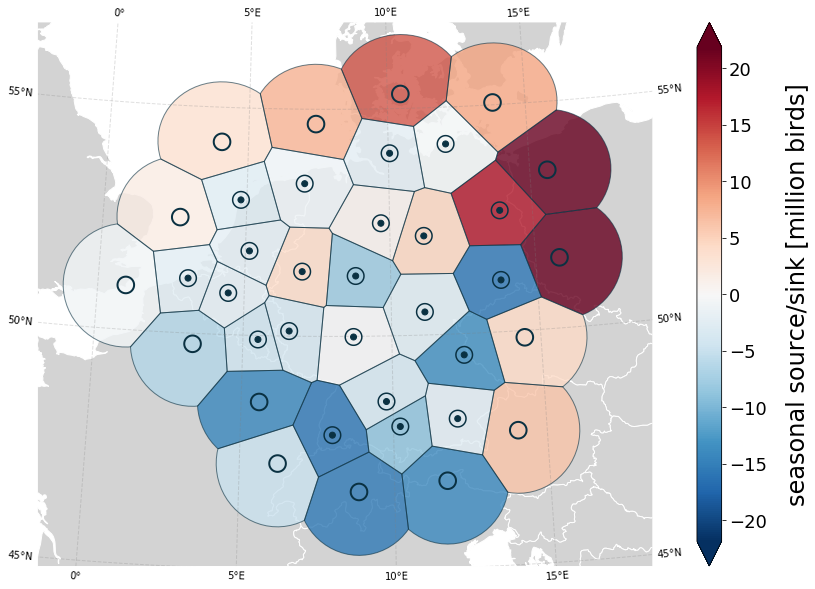

In [176]:
fig, ax = plt.subplots(figsize=(16, 10), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)

trial = 2

voronoi['net_flux'] = voronoi_data[f'net_flux_{trial}'].values / 1e6
voronoi['net_s'] = voronoi_data[f'net_source_sink_{trial}'].values / 1e6
voronoi['net_s'] *= voronoi.area_km2

abs_max_f = max(voronoi[f'net_flux'].max(), -voronoi[f'net_flux'].min())
abs_max_s = max(voronoi[f'net_s'].max(), -voronoi[f'net_s'].min())
abs_max = max(abs_max_f, abs_max_s)
norm = mpl.colors.Normalize(vmin=-abs_max*0.75, vmax=abs_max*0.75)

gplt.choropleth(voronoi.query('boundary == 1'), ax=ax, hue=f'net_flux', 
                norm=norm, cmap='RdBu_r', alpha=0.8, zorder=1)
gplt.choropleth(voronoi.query('boundary == 0'), ax=ax, hue=f'net_s', 
                norm=norm, cmap='RdBu_r', alpha=0.8, zorder=1)
gplt.polyplot(voronoi, ax=ax, 
              edgecolor=c_boundary_light, alpha=0.6, zorder=1)

points = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]
coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 observed = voronoi.observed,
                                 geometry = points), 
                                 crs='epsg:4326').to_crs(crs.proj4_init)

gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), ax=ax, 
              zorder=3, edgecolor=c_marker, extent=extent, linewidth=1.5)
gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), ax=ax, 
              zorder=3, edgecolor=c_marker, extent=extent, linewidth=2)
gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), ax=ax, 
               zorder=4, color=c_marker, extent=extent, s=6)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('RdBu_r'), norm=norm)
cbar = plt.colorbar(sm, extend='both')
cbar.set_label(label='seasonal source/sink [million birds]', size=24, labelpad=18)
cbar.ax.tick_params(labelsize=18) 

fig.savefig(osp.join(output_dir, f'seasonal_source_sink_trial_{trial}.png'), bbox_inches='tight', dpi=200)

In [158]:
influx = []
outflux = []
for t in range(1,6):
    voronoi['net_flux'] = voronoi_data[f'net_flux_{t}'].values / 1e6
    f = voronoi.query('boundary == 1')['net_flux'].values
    influx.append(f[np.where(f > 0)].sum())
    outflux.append(f[np.where(f < 0)].sum())
print(f'influx across boundary: {np.mean(influx)} +/- {np.std(influx)}')
print(f'outflux across boundary: {np.mean(outflux)} +/- {np.std(outflux)}')

96.02534669882813 5.972096400674785
-35.98347836875 17.49991287702018


In [160]:
source = []
sink = []
for t in range(1,6):
    voronoi['net_s'] = voronoi_data[f'net_source_sink_{t}'].values * voronoi.area_km2 / 1e6
    s = voronoi.query('boundary == 0')['net_s'].values
    source.append(s[np.where(s > 0)].sum())
    sink.append(s[np.where(s < 0)].sum())
print(f'total take-off: {np.mean(source)} +/- {np.std(source)}')
print(f'total landing: {np.mean(sink)} +/- {np.std(sink)}')

17.944513326582438 11.532402565535405
-82.83027407563348 16.02097749058474
